<a href="https://colab.research.google.com/github/hscrown/paper_reading/blob/main/VGGNet_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGGNet-11

In [ ]:
# 데이터 전처리
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# CIFAR-100 데이터셋 로드 및 스플릿
(train_X, train_y), (test_X, test_y) = datasets.cifar100.load_data()

# 데이터 정규화 (픽셀 값 범위를 [0, 1]로 변환)
train_X = train_X / 255.0
test_X = test_X / 255.0

# CIFAR-100을 VGGNet 입력 크기인 224x224로 리사이즈
train_X = tf.image.resize(train_X, [224, 224])
test_X = tf.image.resize(test_X, [224, 224])

# 데이터셋 크기 확인
print("Train data shape:", train_X.shape)  # (50000, 224, 224, 3)
print("Test data shape:", test_X.shape)    # (10000, 224, 224, 3)

Train data shape: (50000, 224, 224, 3)
Test data shape: (10000, 224, 224, 3)


In [ ]:
# VGGNet-11 모델 정의
model = tf.keras.Sequential([
    # 첫 번째 컨볼루션 레이어 그룹
    # 1. 첫 번째 Conv2D 레이어:
    #    - 입력 크기: (224, 224, 3) - 224x224 크기의 컬러 이미지
    #    - 필터 수: 64개 - 64개의 다른 특징을 학습
    #    - 커널 크기: (3, 3) - 3x3 크기의 필터를 사용해 작은 특징을 추출
    #    - 활성화 함수: ReLU - 음수를 0으로 변환하여 비선형성을 추가하고 학습 속도를 빠르게 함
    tf.keras.layers.Conv2D(input_shape=(224, 224, 3), kernel_size=(3, 3), filters=64, activation='relu'),

    # 2. 두 번째 Conv2D 레이어:
    #    - 필터 수: 64개 - 첫 번째 Conv 레이어에서 학습한 특징을 더욱 강화
    #    - 커널 크기: (3, 3) - 두 번째 3x3 필터로 특징 맵을 더욱 세밀하게 학습
    #    - 활성화 함수: ReLU - 비선형성을 추가하여 모델의 표현력 향상
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu'),

    # 3. MaxPooling 레이어:
    #    - 풀 크기: (2, 2) - 2x2 영역에서 가장 큰 값만 남김
    #    - 스트라이드: (2, 2) - 특성 맵 크기를 절반으로 줄임
    #    - 역할: 특성 맵의 크기를 줄여서 계산 효율성을 높이고, 가장 중요한 특징만 남겨서 과적합 방지에 도움
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    # 두 번째 컨볼루션 레이어 그룹
    # 필터 수 128개로 증가하여 더 복잡한 특징 학습
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    # 세 번째 컨볼루션 레이어 그룹
    # 필터 수 256개로 증가하여 더욱 미세한 특징 학습
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=256, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    # 네 번째 컨볼루션 레이어 그룹
    # 필터 수 512개로 복잡한 특징 학습
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=512, activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=512, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    # 완전 연결 레이어
    # Flatten 레이어: 다차원 배열을 1차원으로 펼쳐 완전 연결 레이어에 전달
    tf.keras.layers.Flatten(),
    # Dense 레이어 (4096 units): 고차원 특성들을 학습하는 완전 연결층
    tf.keras.layers.Dense(units=4096, activation='relu'),
    # Dense 레이어 (4096 units): 높은 차원의 복잡한 특징을 학습하는 추가 완전 연결층
    tf.keras.layers.Dense(units=4096, activation='relu'),
    # 출력 레이어: 100개의 클래스로 CIFAR-100 데이터셋 분류
    tf.keras.layers.Dense(units=100, activation='softmax')
])

# 모델 컴파일
# Adam 옵티마이저 사용: 경사하강법을 기반으로 학습 속도를 자동으로 조정해 효율적인 학습을 도움
# 손실 함수로 sparse_categorical_crossentropy 사용: CIFAR-100은 정수형 레이블을 갖는 다중 클래스 분류 문제에 적합
# - sparse_categorical_crossentropy: 정수형 레이블을 직접 사용 가능하여 원-핫 인코딩이 필요 없음
# - categorical_crossentropy: 다중 클래스 분류에 사용, 원-핫 인코딩된 레이블을 필요로 함
# - binary_crossentropy: 이진 분류 문제에 사용, 레이블이 두 개(예: 0과 1)인 경우 적합
# - 다중 클래스 분류에 적합하고 메모리 및 계산 효율성을 높여줌
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약 정보 출력 (각 레이어의 출력 형태와 파라미터 수 확인)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                 

In [ ]:
# 모델 학습
history = model.fit(train_X, train_y, epochs=2, validation_split=0.2)

Epoch 1/2
1250/1250 [==============================] - 4900s 4s/step - loss: 4.6061 - accuracy: 0.0098 - val_loss: 4.6065 - val_accuracy: 0.0089
Epoch 2/2
1250/1250 [==============================] - 4928s 4s/step - loss: 4.6057 - accuracy: 0.0095 - val_loss: 4.6073 - val_accuracy: 0.0085


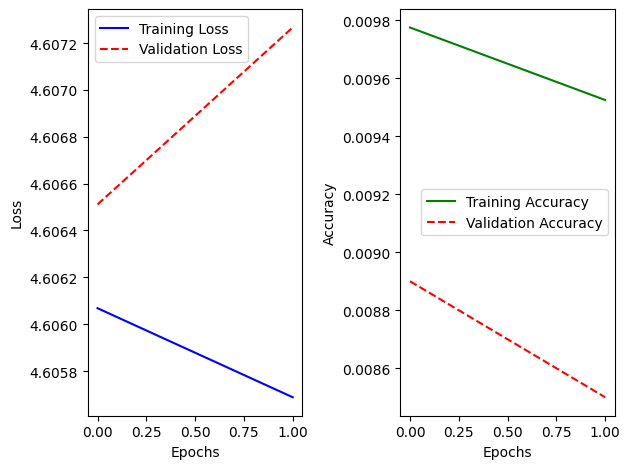

In [ ]:
# 결과 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 성능 평가
test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 4.605373859405518, Test Accuracy: 0.009999999776482582
